In [1]:
# packages
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
import os, glob
from sklearn.metrics import r2_score, mean_squared_error

from utils.pyfunctions import *

In [2]:
# Setup your PBSCluster
import dask
from dask_jobqueue import PBSCluster
from dask.distributed import Client
ncores=1
nmem='10GB'
cluster = PBSCluster(
    cores=ncores, # The number of cores you want
    memory=nmem, # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR', # Use your local directory
    resource_spec='select=1:ncpus='+str(ncores)+':mem='+nmem, # Specify resources
    project='P93300641', # Input your project ID here
    walltime='03:00:00', # Amount of wall time
    #interface='ib0', # Interface to use
)

# Scale up
cluster.scale(10)

# Setup your client
client = Client(cluster)

/glade/u/home/linnia/miniconda3/envs/ppe-py/lib/python3.7/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile
/glade/u/home/linnia/miniconda3/envs/ppe-py/lib/python3.7/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41833 instead
  f"Port {expected} is already in use.\n"


In [3]:
dvs = ['FLDS','FSDS','RH2M','RAIN','SNOW','TSA',
            'FGR12','FIRE','FSR','FSH','EFLX_LH_TOT',
            'SOILWATER_10CM','TSOI','H2OSNO','QVEGE','QVEGT','QSOIL','QRUNOFF',
            'TOTSOMC_1m','AR','HR','NEE','NBP','TLAI','GPP','TOTVEGC',
            'FAREA_BURNED','FSA', 'FFIX_TO_SMINN', 'TREFMXAV', 'TREFMNAV', 'NPP']

### Load sparsegrid CRUJRA

In [36]:
la=xr.open_dataset('./utils/sparsegrid_landarea.nc').landarea

In [31]:
yy = (1986,2015)
dir='/glade/campaign/cgd/tss/projects/PPE/ctsm530_OAAT/hist/'
key = './clm6_minioaat.csv'
exp='oaat'
tape='h0'
utils_path = '/glade/u/home/linnia/CLM6-PPE/clm6-oaat/utils/'

In [32]:
ds= get_exp(exp,dir,key,dvs,'h0',yy,utils_path)
default = ds.isel(ens=100)

In [7]:
dvs=['TLAI','GPP','NPP','TOTVEGC','NBP','EFLX_LH_TOT']
sparse_amean = xr.Dataset({v:amean(default[v]) for v in dvs})
sparse_cru_agmean = gmean(sparse_amean,la)

In [8]:
tmp = default['TSOI']
da = get_map(tmp)
sparse_cru_map = da.to_dataset()

for var in dvs:
    tmp = default[var]
    sparse_cru_map[var] = get_map(tmp)

In [63]:
# try with new h0 mapping 
new_la = xr.open_dataset('landarea_retrain_h0.nc').landarea
dvs=['TLAI','GPP','NPP','TOTVEGC','NBP','EFLX_LH_TOT']
sparse_amean_new = xr.Dataset({v:amean(default[v]) for v in dvs})
sparse_cru_agmean_new = gmean(sparse_amean_new,new_la)

In [34]:
sgmap = xr.open_dataset('sgmap_retrain_h0.nc')
tmp = default['TLAI']
da = get_map(tmp,sgmap)
sparse_cru_map_new = da.to_dataset()

for var in dvs:
    tmp = default[var]
    sparse_cru_map_new[var] = get_map(tmp,sgmap)

### Load GSWP3

In [79]:
# sparse grid
la=xr.open_dataset('./utils/sparsegrid_landarea.nc').landarea
ds_sparse = xr.open_dataset('clm5.1_gswp3_default.nc')

dvs=['TLAI','GPP','NPP','TOTVEGC','NBP','EFLX_LH_TOT']
sparse_gsw_amean = xr.Dataset({v:amean(ds_sparse[v]) for v in dvs})
sparse_gsw_agmean = gmean(sparse_gsw_amean,la)

In [80]:
tmp = ds_sparse['TLAI']
da = get_map(tmp)
sparse_gsw_map = da.to_dataset()

for var in dvs:
    tmp = ds_sparse[var]
    sparse_gsw_map[var] = get_map(tmp)

In [73]:
# full grid
d='/glade/campaign/cgd/tss/people/oleson/PPE/clm51_lmbirchwkattgen01ctsm51d006_2deg_GSWP3V1_nocrop_PPE2_hist/lnd/hist/'
files=sorted(glob.glob(d+'*h0*'))[-360:]

def preprocess(ds):
    dvs=['TLAI','TWS','GPP','NPP','NBP','TOTVEGC','TOTSOMC','TOTECOSYSC','EFLX_LH_TOT','area','landfrac']
    return ds[dvs]

ds=xr.open_mfdataset(files,combine='nested',concat_dim='time',parallel=True,
                     preprocess=preprocess,decode_times=False)
ds['time']=xr.cftime_range('1985',periods=360,freq='MS')

In [76]:
full_gsw_amean = xr.Dataset({v:amean(ds[v]) for v in ds.data_vars})

In [77]:
la_full = (ds.area*ds.landfrac).mean(dim='time')
la_full = la_full.where(la_full['lat']>=-60)
weighted_data = full_gsw_amean * la_full
full_gsw_agmean = weighted_data.sum(dim=['lat', 'lon'])/la_full.sum().values

### Load full grid simulation

In [49]:
def preprocess(ds):
    dvs=['TLAI','TWS','GPP','NPP','NBP','TOTVEGC','TOTSOMC','TOTECOSYSC','EFLX_LH_TOT','area','landfrac']
    return ds[dvs]

In [50]:
path = '/glade/derecho/scratch/oleson/archive/ctsm530_f19_PPE_hist/lnd/hist/'
yy = (1986,2015)

files =glob.glob(path+'*.h0.*')
f=sorted(files)

ds=xr.open_mfdataset(f[1632:1992],combine='nested',concat_dim=['time'],
                 preprocess=preprocess,decode_times=False,parallel=True)
ds['time']=xr.cftime_range(str(1986),periods=len(ds.time),freq='MS',calendar='noleap')

In [51]:
full_cru_amean = xr.Dataset({v:amean(ds[v]) for v in ds.data_vars})

In [57]:
la_full = (ds.area*ds.landfrac).mean(dim='time')
la_full = la_full.where(la_full['lat']>=-60)
weighted_data = full_cru_amean * la_full # convert from km2 to m2
full_cru_agmean = weighted_data.sum(dim=['lat', 'lon'])/la_full.sum().values

### Map rmse (year)

TLAI 0.5825163557160944
GPP 257.2813724862192
NPP 109.58396262551081
TOTVEGC 1538.5624561792422
NBP 54.66129561198453
EFLX_LH_TOT 7.375207510791962


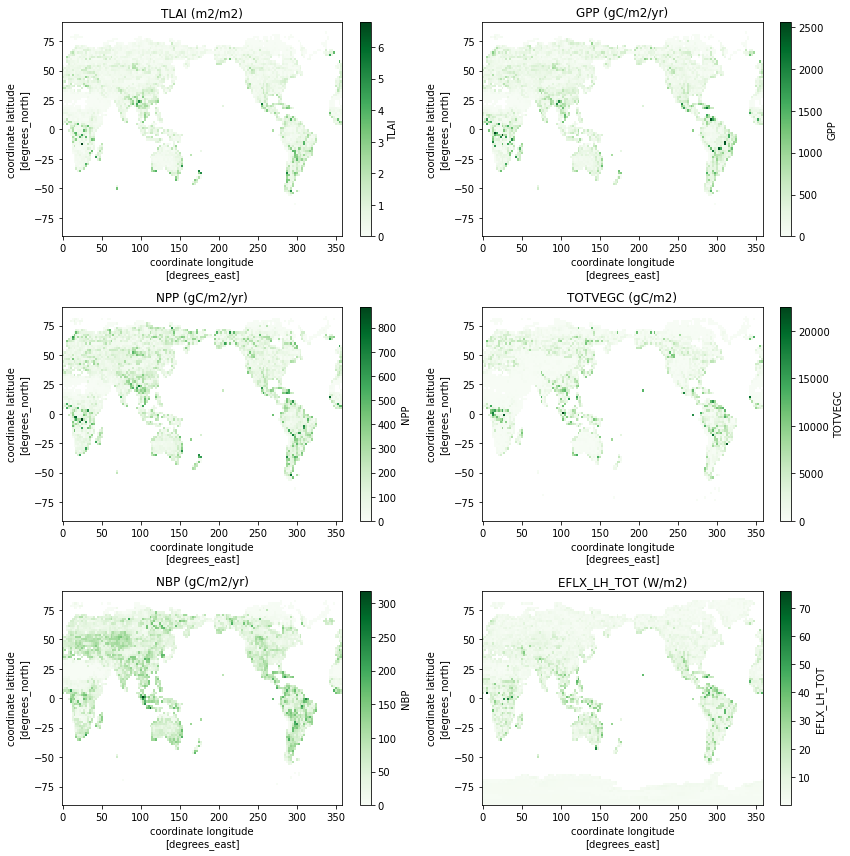

In [21]:
plt.figure(figsize=(12,12))
dvs=['TLAI','GPP','NPP','TOTVEGC','NBP','EFLX_LH_TOT']
cf=24*60*60*365
cfs = [1,cf,cf,1,cf,1]
units=[' (m2/m2)',' (gC/m2/yr)',' (gC/m2/yr)',' (gC/m2)',' (gC/m2/yr)',' (W/m2)']
la = la.where(la['lat']>=-60)

for i,var in enumerate(dvs):
    error = cfs[i]*(amean(sparse_cru_map)[var] - full_cru_amean[var]).compute()
    rmse = np.sqrt((error ** 2).mean(dim='year'))
    rmse = rmse.where(rmse != 0, np.nan)

    rmse_gmean = (rmse * la).sum(dim=['lat', 'lon'])/la.sum().values
    print(var, rmse_gmean.values)
    
    plt.subplot(3,2,i+1)
    rmse.plot(cmap='Greens')
    plt.title(var+units[i])
plt.tight_layout()
#plt.savefig('./figs/sparsegrid_evaluation_rmse_maps.png')

TLAI 0.5583425490215415
GPP 248.13341791225048
NPP 104.2983950224722
TOTVEGC 1499.2184268676433
NBP 54.492340809828114
EFLX_LH_TOT 7.284435078375276


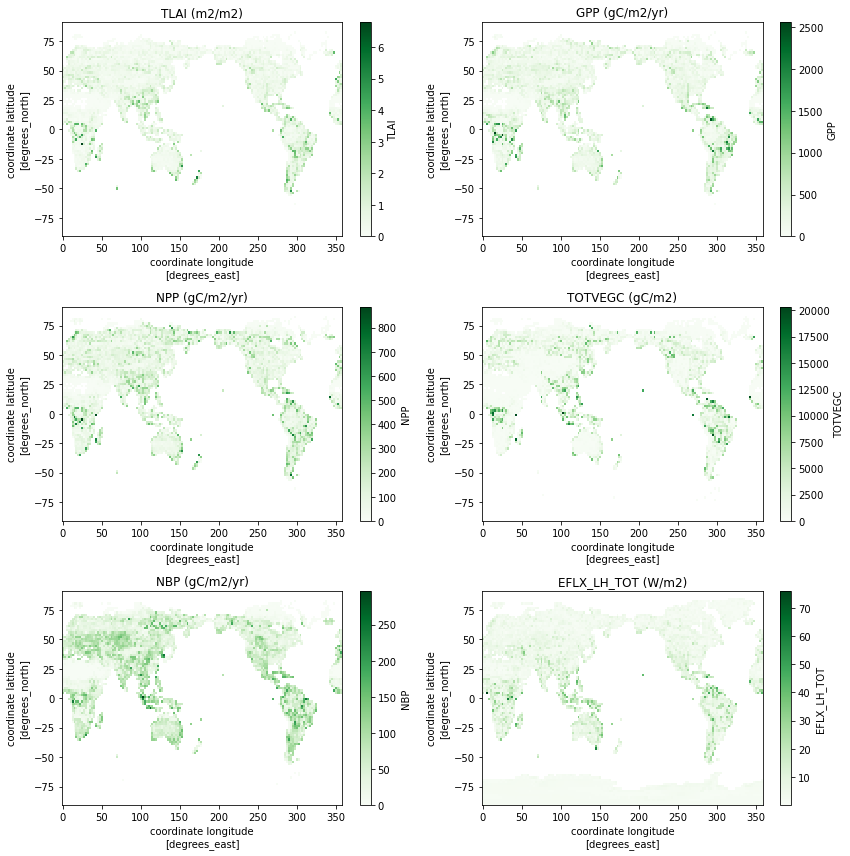

In [58]:
# CTSM6 w/CRUJRA mapping
plt.figure(figsize=(12,12))
dvs=['TLAI','GPP','NPP','TOTVEGC','NBP','EFLX_LH_TOT']
cf=24*60*60*365
cfs = [1,cf,cf,1,cf,1]
units=[' (m2/m2)',' (gC/m2/yr)',' (gC/m2/yr)',' (gC/m2)',' (gC/m2/yr)',' (W/m2)']

for i,var in enumerate(dvs):
    error = cfs[i]*(amean(sparse_cru_map_new)[var] - full_cru_amean[var]).compute()
    rmse = np.sqrt((error ** 2).mean(dim='year'))
    rmse = rmse.where(rmse != 0, np.nan)

    rmse_gmean = (rmse * la_full).sum(dim=['lat', 'lon'])/la.sum().values
    print(var, rmse_gmean.values)
    
    plt.subplot(3,2,i+1)
    rmse.plot(cmap='Greens')
    plt.title(var+units[i])
plt.tight_layout()
#plt.savefig('./figs/sparsegrid_evaluation_rmse_maps_newsgmap.png')

TLAI 0.501768572319104
GPP 191.71587871317595
NPP 89.12685959221831
TOTVEGC 1214.9529250334522
NBP 56.22361172289524
EFLX_LH_TOT 7.0736268135699


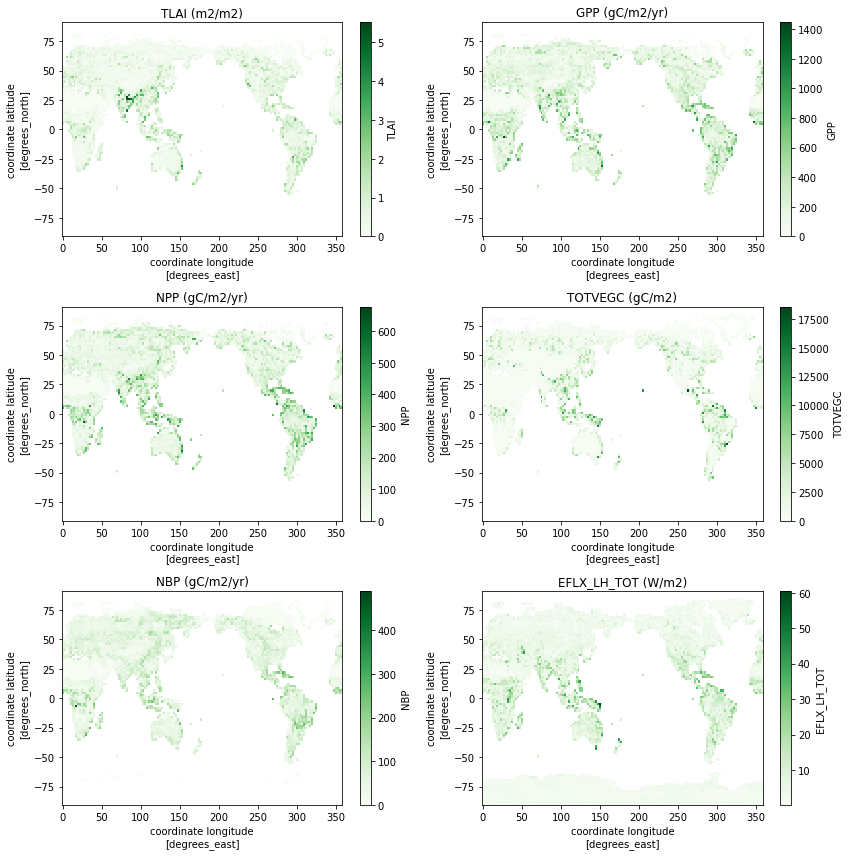

In [86]:
# CLM5.1 with GSWP3 
plt.figure(figsize=(12,12))
dvs=['TLAI','GPP','NPP','TOTVEGC','NBP','EFLX_LH_TOT']
cf=24*60*60*365
cfs = [1,cf,cf,1,cf,1]
units=[' (m2/m2)',' (gC/m2/yr)',' (gC/m2/yr)',' (gC/m2)',' (gC/m2/yr)',' (W/m2)']

for i,var in enumerate(dvs):
    error = cfs[i]*(amean(sparse_gsw_map)[var] - full_gsw_amean[var]).compute()
    rmse = np.sqrt((error ** 2).mean(dim='year'))
    rmse = rmse.where(rmse != 0, np.nan)

    rmse_gmean = (rmse * la_full).sum(dim=['lat', 'lon'])/la.sum().values
    print(var, rmse_gmean.values)
    
    plt.subplot(3,2,i+1)
    rmse.plot(cmap='Greens')
    plt.title(var+units[i])
plt.tight_layout()
plt.savefig('./figs/sparsegrid_evaluation_rmse_maps_clm5gswp3.png')

### Global mean

In [14]:
def add11():
    # Get current axis limits
    xmin, xmax = plt.gca().get_xlim()
    ymin, ymax = plt.gca().get_ylim()
    
    # Determine min and max for the 1:1 line
    line_min = min(xmin, ymin)
    line_max = max(xmax, ymax)
    
    # Plot the 1:1 line
    plt.plot([line_min, line_max], [line_min, line_max], color='k', linestyle='--', label="1:1 Line")


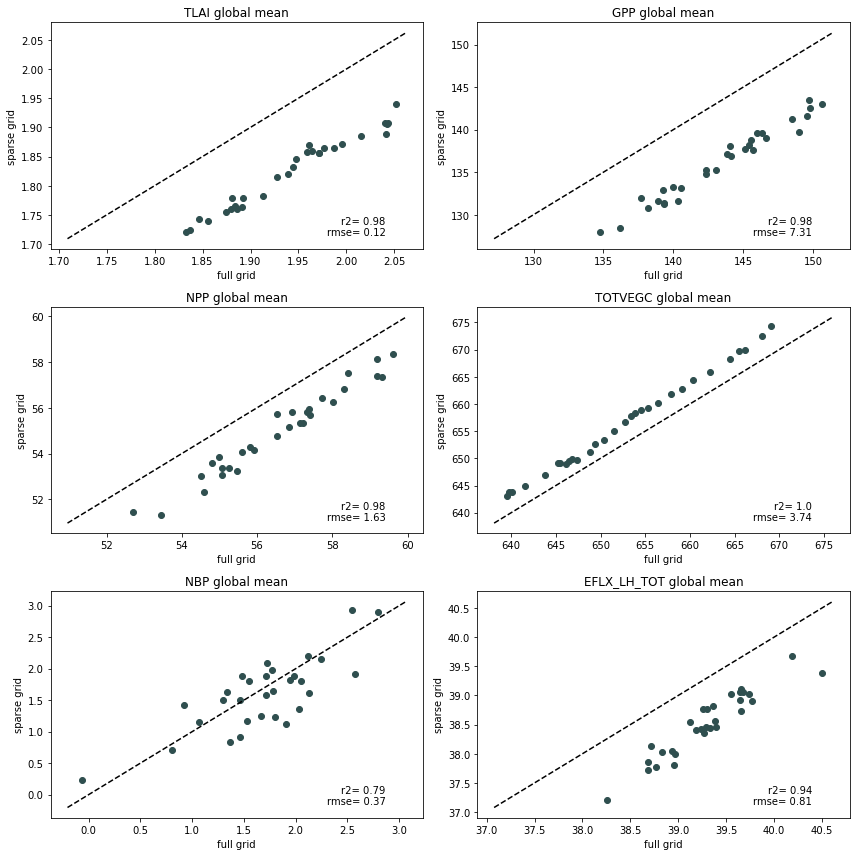

In [182]:
dvs=['TLAI','GPP','NPP','TOTVEGC','NBP','EFLX_LH_TOT']
cf=24*60*60*365*1e-9*la_sparse.sum().values
cfs = [1,cf,cf,1e-9*la.sum().values,cf,1]
units=[' (m2/m2)',' (PgC)',' (PgC)',' (PgC)',' (PgC)',' (W/m2)']

plt.figure(figsize=(12,12))
for i,v in enumerate(dvs):
    plt.subplot(3,2,i+1)
    x = cfs[i]*full_cru_agmean[v].values
    y = cfs[i]*sparse_cru_agmean[v].values
    plt.scatter(x,y,c='darkslategrey')
    
    add11()
    plt.text(0.90, 0.1, "r2= "+str(np.round(np.corrcoef(x, y)[0,1],2)), ha='right', va='bottom', transform=plt.gca().transAxes)
    plt.text(0.90, 0.05, "rmse= "+str(round(mean_squared_error(x,y)**0.5,2)), ha='right', va='bottom', transform=plt.gca().transAxes)
    plt.title(v + ' global mean')
    plt.xlabel('full grid')
    plt.ylabel('sparse grid')
plt.tight_layout()
plt.savefig('./figs/sparsegrid_evaluation_globalmean.png')

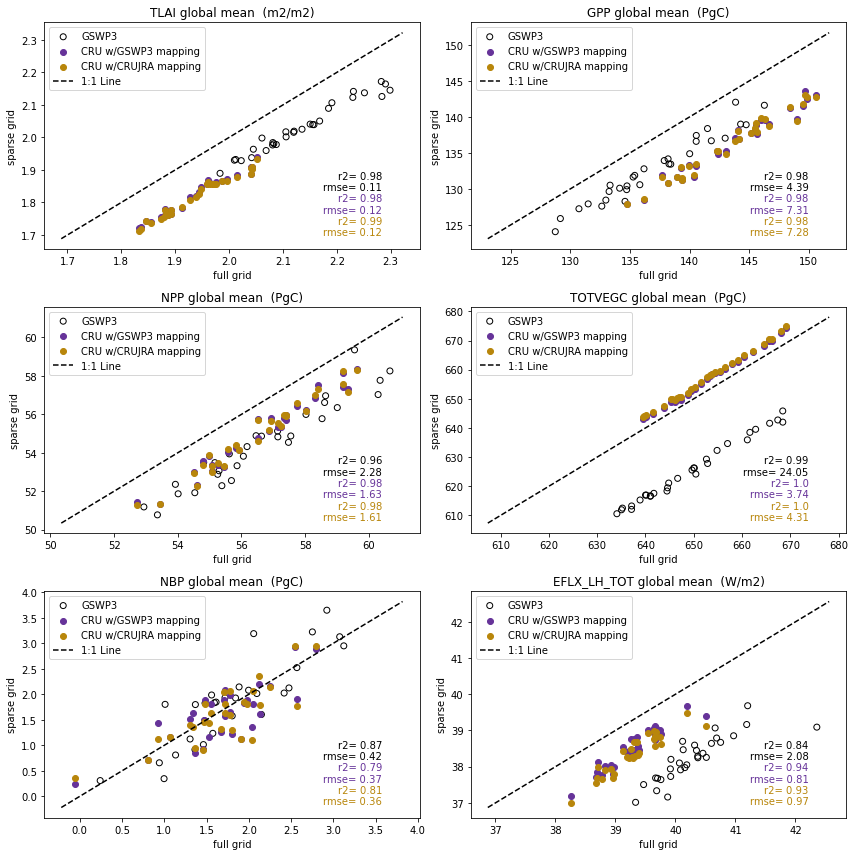

In [89]:
la_sparse=xr.open_dataset('./utils/sparsegrid_landarea.nc').landarea

dvs=['TLAI','GPP','NPP','TOTVEGC','NBP','EFLX_LH_TOT']
cf=24*60*60*365*1e-9*la_sparse.sum().values
cfs = [1,cf,cf,1e-9*la.sum().values,cf,1]
units=[' (m2/m2)',' (PgC)',' (PgC)',' (PgC)',' (PgC)',' (W/m2)']

plt.figure(figsize=(12,12))
for i,v in enumerate(dvs):
    plt.subplot(3,2,i+1)
    x = cfs[i]*full_gsw_agmean[v].values
    y = cfs[i]*sparse_gsw_agmean[v].values
    plt.scatter(x,y,label='GSWP3',marker='o', facecolors='none', edgecolors='k')
    plt.text(0.90, 0.3, "r2= "+str(np.round(np.corrcoef(x, y)[0,1],2)), ha='right', va='bottom', transform=plt.gca().transAxes,color='k')
    plt.text(0.90, 0.25, "rmse= "+str(round(mean_squared_error(x,y)**0.5,2)), ha='right', va='bottom', transform=plt.gca().transAxes,color='k')
    

    x = cfs[i]*full_cru_agmean[v].values
    y = cfs[i]*sparse_cru_agmean[v].values
    plt.scatter(x,y,c='rebeccapurple',label='CRU w/GSWP3 mapping')
    plt.text(0.90, 0.2, "r2= "+str(np.round(np.corrcoef(x, y)[0,1],2)), ha='right', va='bottom', transform=plt.gca().transAxes,color='rebeccapurple')
    plt.text(0.90, 0.15, "rmse= "+str(round(mean_squared_error(x,y)**0.5,2)), ha='right', va='bottom', transform=plt.gca().transAxes,color='rebeccapurple')
    
    x = cfs[i]*full_cru_agmean[v].values
    y = cfs[i]*sparse_cru_agmean_new[v].values
    plt.scatter(x,y,c='darkgoldenrod',label='CRU w/CRUJRA mapping')
    
    add11()
    plt.text(0.90, 0.1, "r2= "+str(np.round(np.corrcoef(x, y)[0,1],2)), ha='right', va='bottom', transform=plt.gca().transAxes,color='darkgoldenrod')
    plt.text(0.90, 0.05, "rmse= "+str(round(mean_squared_error(x,y)**0.5,2)), ha='right', va='bottom', transform=plt.gca().transAxes,color='darkgoldenrod')
    plt.title(v + ' global mean '+ units[i])
    plt.xlabel('full grid')
    plt.ylabel('sparse grid')
    plt.legend()
plt.tight_layout()
plt.savefig('./figs/sparsegrid_evaluation_globalmean_GSWP3+CRU+CRUJRAmapping.png')